In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]= (10,2)
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")
import plotly.express as px
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.impute import KNNImputer


In [2]:
def sliderPlot(df1,t=None):
    if t =="line":
        fig = px.line(x=df1.index, y=df1)
    else:
        fig = px.scatter(x=df1.index, y=df1)
    fig.update_xaxes(
        rangeslider_visible=True,
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(count=2, label="2y", step="year", stepmode="backward"),
                dict(count=3, label="3y", step="year", stepmode="backward"),
                dict(step="all")
            ])))
    fig.show()
    return
def scatter(df1):
    plt.scatter(df1.index, df1, color='k',s=10)
    plt.xlabel('timestamp')
    # plt.title('current')
    plt.show()

def create_features(hourly_data):
    hourly_data = hourly_data.copy()
    # Check if the index is in datetime format
    if not isinstance(hourly_data.index, pd.DatetimeIndex):
        hourly_data.index = pd.to_datetime(hourly_data.index)
    
    hourly_data['sec'] = hourly_data.index.second
    hourly_data['minute'] = hourly_data.index.minute
    hourly_data['hour'] = hourly_data.index.hour
    hourly_data['day'] = hourly_data.index.day
    hourly_data['dayofweek'] = hourly_data.index.dayofweek
    hourly_data['weekofyear'] = hourly_data.index.isocalendar().week
    hourly_data['month'] = hourly_data.index.month
    hourly_data['quarter'] = hourly_data.index.quarter

    return hourly_data

In [19]:
""" data ingestion """

lst = ['wm',"ac1",'ac2',"f",'tv']
path = "d:/NILM/Data_files/Parquet/Appliances12_06_04_08/"

""" data ingestion done """

""" data validation and transformation """
complete_data_lst = []
date_dit ={}
for i in range(len(lst)):
    counter = 0
    dit = {}
    df = pd.read_parquet(f"{path}{lst[i]}.parquet")
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.drop_duplicates(inplace=True)
    df.set_index(['timestamp'],inplace=True ,drop=True)  
    df.drop(df[(df['frequency']>51) | (df['frequency']<49)].index, inplace=True)
    df.drop(df[(df['PF']>1) | (df['PF']<0)].index, inplace=True)
    # df.drop(df[(df['current']>20) |(df['current']<0.07)].index, inplace=True)
    df.drop(df[df['voltage']<140].index, inplace=True)
    
    """ data validation done """
    
    """ data transformation """
    df['power'] = (df['voltage'] * df['current'] * df['PF']).round(2)
    if lst[i]=="f":
        df_appliance = df[['power',"voltage",'current']].resample(rule="1s").asfreq()
        df_appliance = df_appliance.rename(columns={'power': f'{lst[i]}_A', 'voltage': f'{lst[i]}_V', 'current': f'{lst[i]}_C'})
        unique_dates = pd.Series(df.index.date).unique()
        # for date1 in unique_dates:
        #     hours_lst = []
        #     df_date = df[df.index.to_series().dt.date == date1]
        #     hours = df_date.index.hour.unique()
        #     for y in hours:
        #         hours_lst.append(y)
        #         counter+=1
        #     dit[f"{date1}"] = hours_lst
    else:
        df_sample_lst = []
        unique_dates = pd.Series(df.index.date).unique()
        for date1 in unique_dates:
            hours_lst = []
            df_date = df[df.index.to_series().dt.date == date1]
            hours = df_date.index.hour.unique()
            for y in hours:
                hours_lst.append(y)
                date2 = f"{date1} {y:02d}"
                df_hour = df_date.loc[date2]
                df_resampled_hour = df_hour[['power',"voltage",'current']].resample(rule="1s").asfreq()
                df_sample_lst.append(df_resampled_hour)
                counter+=1
            
            dit[f"{date1}"] = hours_lst

        df_appliance = pd.concat(df_sample_lst)
        df_appliance = df_appliance.rename(columns={'power': f'{lst[i]}_A', 'voltage': f'{lst[i]}_V', 'current': f'{lst[i]}_C'})

    date_dit[f"{lst[i]}"] = dit
    print(lst[i])
    print("days when appliance is active :", len(unique_dates))
    print("no. of hours:", counter)
    complete_data_lst.append(df_appliance)


wm
days when appliance is active : 14
no. of hours: 26
ac1
days when appliance is active : 50
no. of hours: 148
ac2
days when appliance is active : 46
no. of hours: 207
f
days when appliance is active : 54
no. of hours: 0
tv
days when appliance is active : 37
no. of hours: 285


In [20]:
df = complete_data_lst[1]
df

,ac1_A,ac1_V,ac1_C
timestamp,,,
2013-06-12 15:37:44,1695.42,206.51,8.318
2013-06-12 15:37:45,1693.94,206.49,8.320
2013-06-12 15:37:46,1692.68,206.57,8.319
2013-06-12 15:37:47,1693.01,206.50,8.315
2013-06-12 15:37:48,1693.09,206.56,8.313
...,...,...,...
2013-08-03 17:32:16,1695.33,203.78,8.429
2013-08-03 17:32:17,1698.77,203.82,8.453
2013-08-03 17:32:18,1697.96,203.83,8.440


In [21]:
df.isna().sum()

ac1_A    9874
ac1_V    9874
ac1_C    9874
dtype: int64

In [22]:
import numpy as np
import pandas as pd
from scipy.interpolate import CubicSpline

for column in df.columns:
    # Replace missing values with NaNs in the current column
    missing_indices = df[column].index[df[column].isna()]
    non_missing_indices = df[column].index[df[column].notna()]

    # Convert timestamps to numerical values
    non_missing_indices_numeric = non_missing_indices.to_numpy()
    missing_indices_numeric = missing_indices.to_numpy()

    # Create a cubic spline interpolation function for the current column
    cs = CubicSpline(non_missing_indices_numeric, df[column].dropna().to_numpy(), bc_type='natural')

    # Interpolate missing values in the current column
    df.loc[missing_indices, column] = cs(missing_indices_numeric)

# Display the DataFrame with interpolated values
df


,ac1_A,ac1_V,ac1_C
timestamp,,,
2013-06-12 15:37:44,1695.42,206.51,8.318
2013-06-12 15:37:45,1693.94,206.49,8.320
2013-06-12 15:37:46,1692.68,206.57,8.319
2013-06-12 15:37:47,1693.01,206.50,8.315
2013-06-12 15:37:48,1693.09,206.56,8.313
...,...,...,...
2013-08-03 17:32:16,1695.33,203.78,8.429
2013-08-03 17:32:17,1698.77,203.82,8.453
2013-08-03 17:32:18,1697.96,203.83,8.440


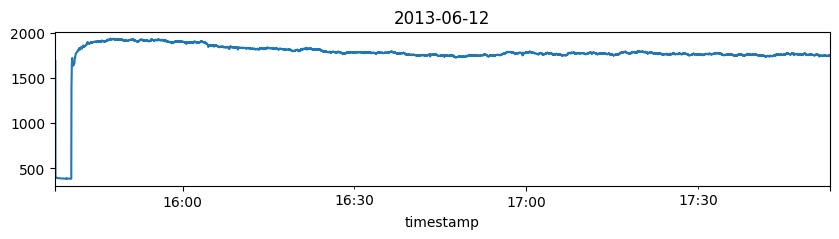

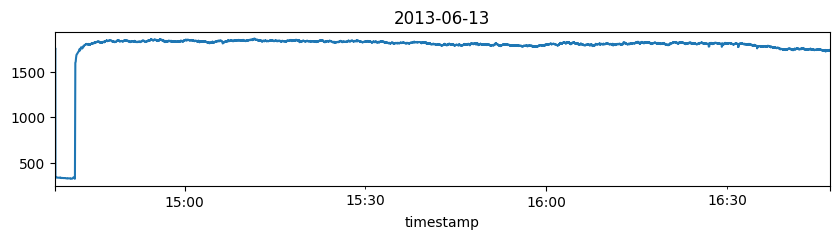

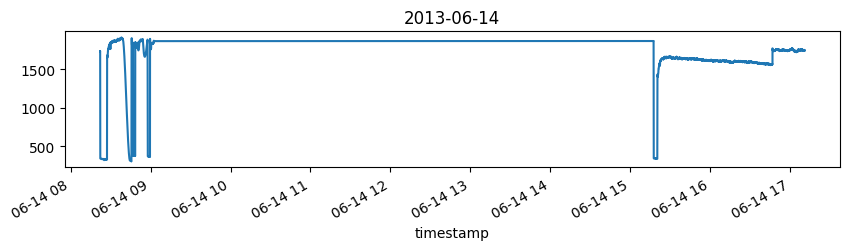

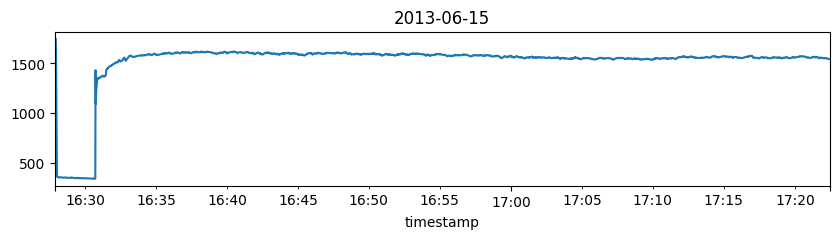

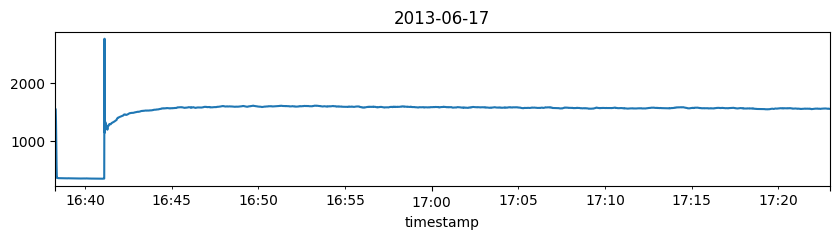

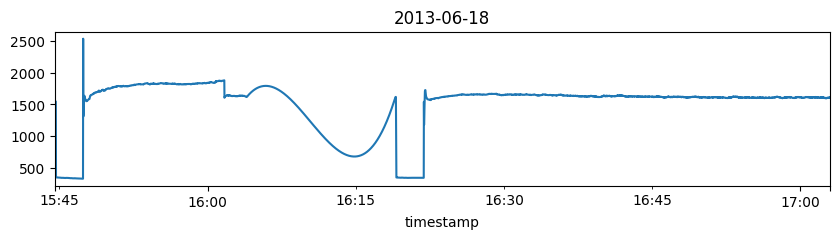

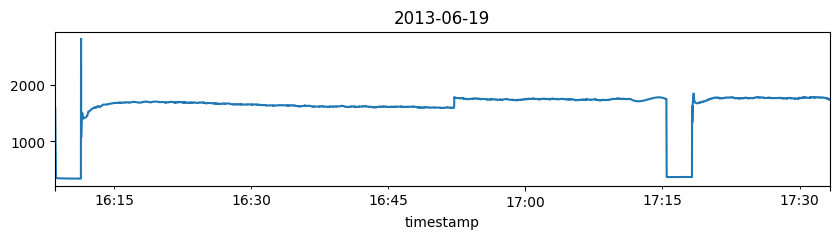

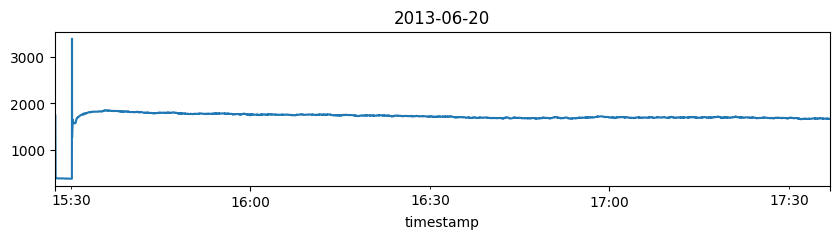

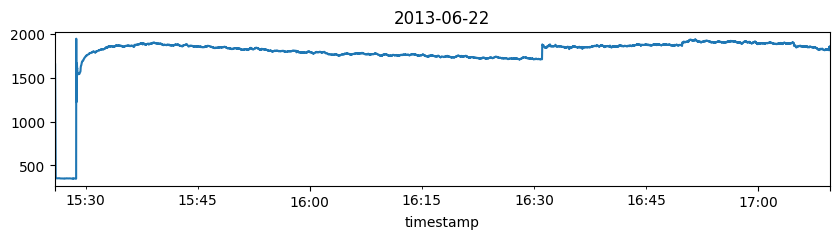

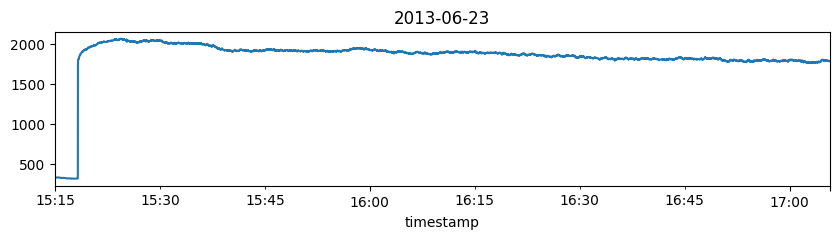

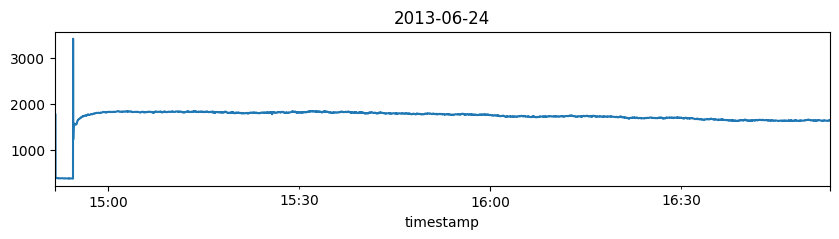

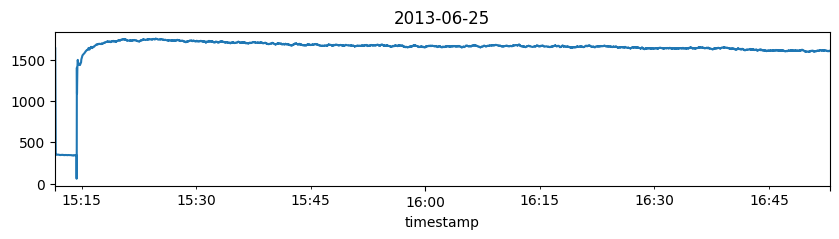

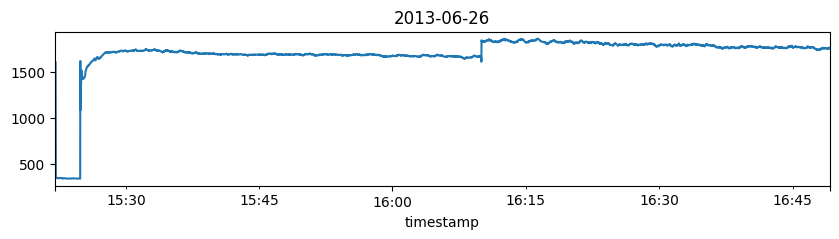

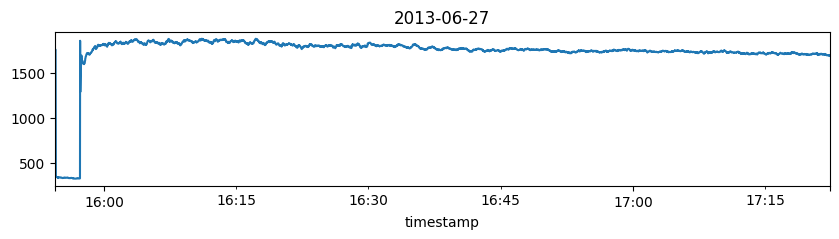

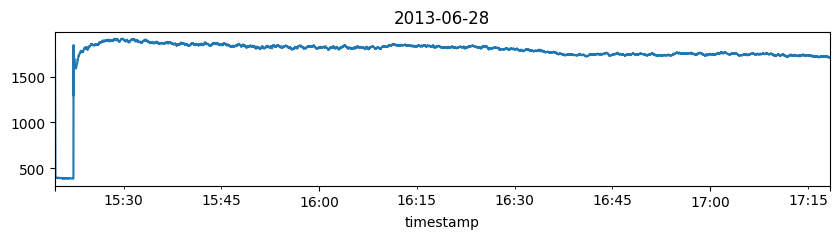

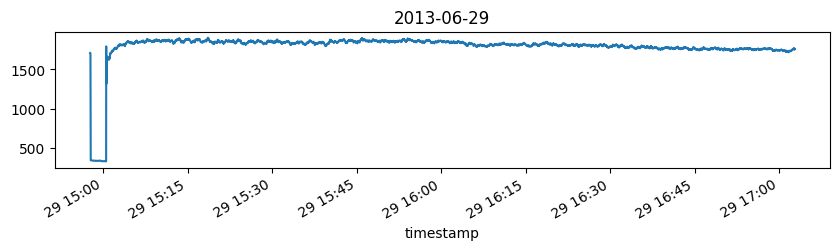

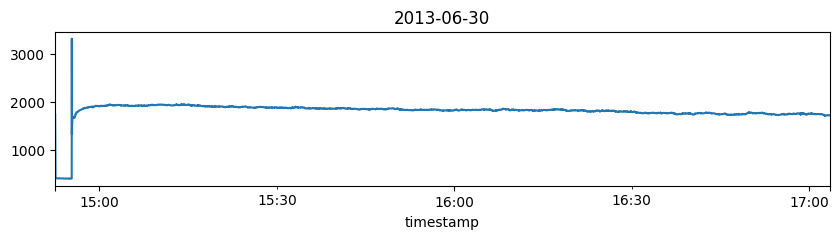

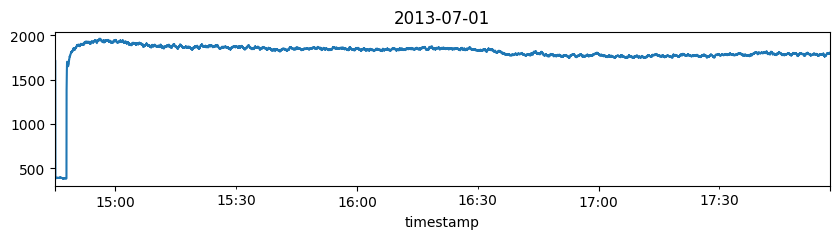

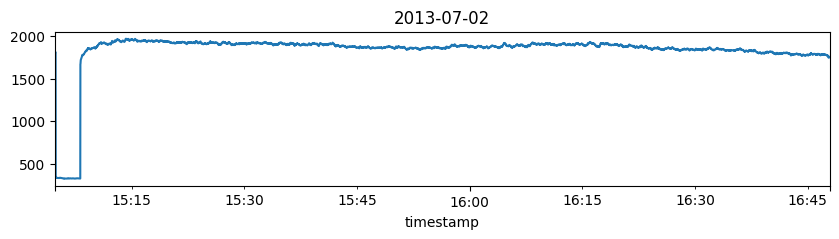

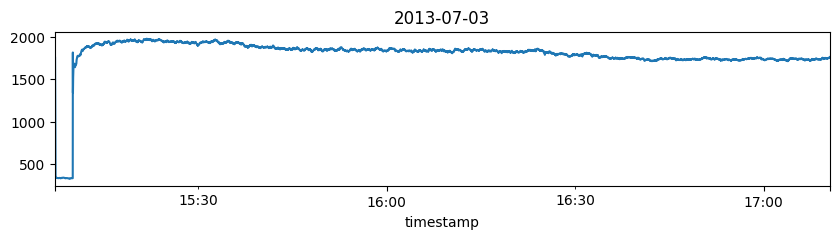

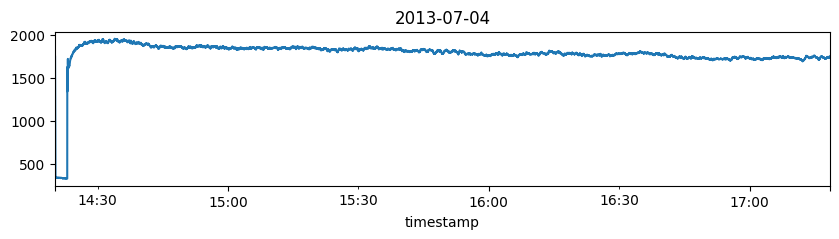

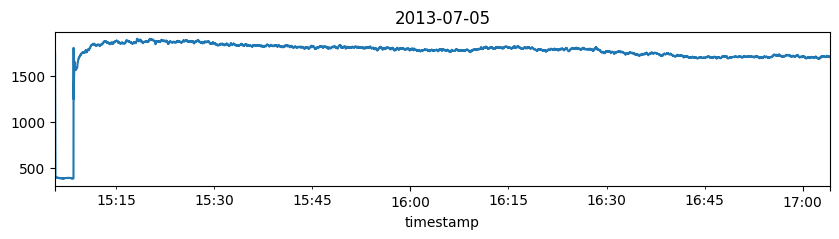

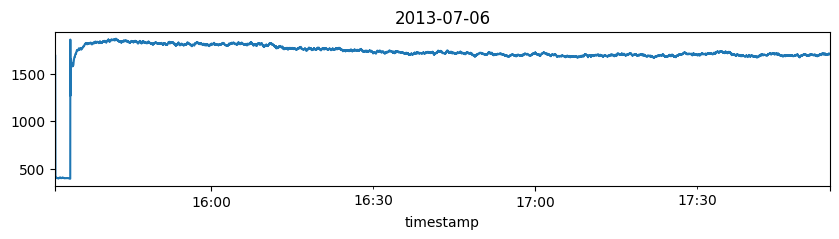

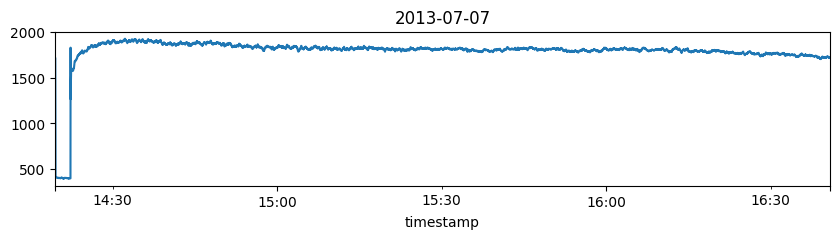

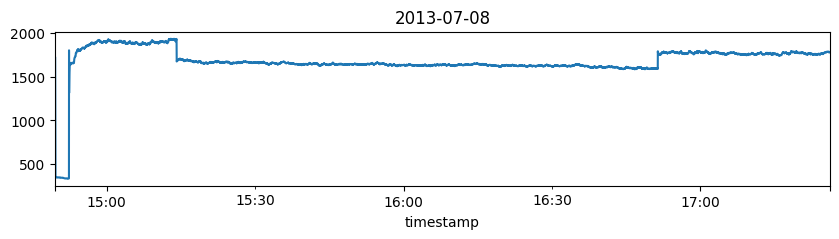

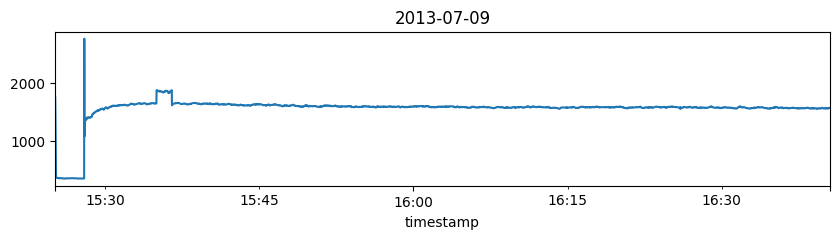

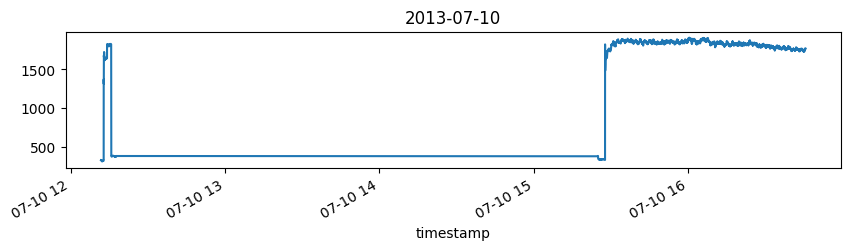

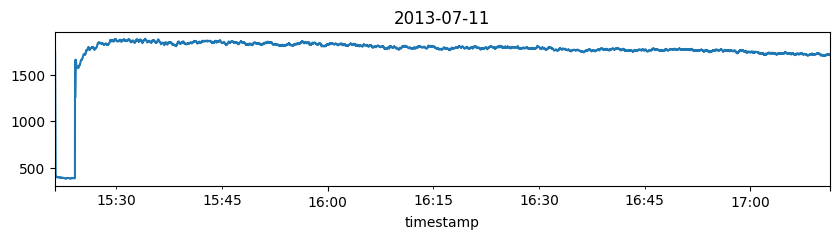

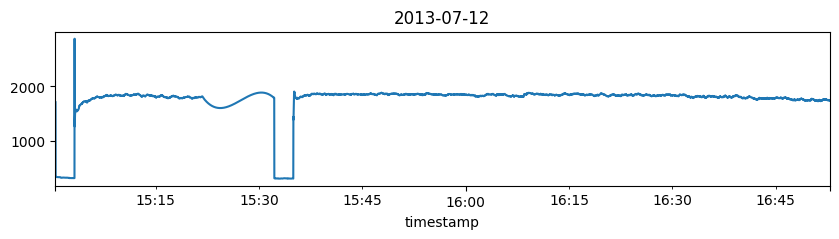

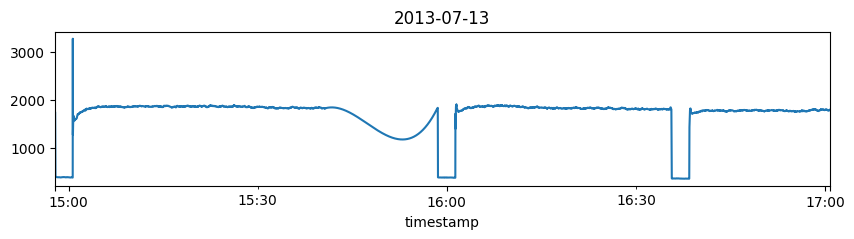

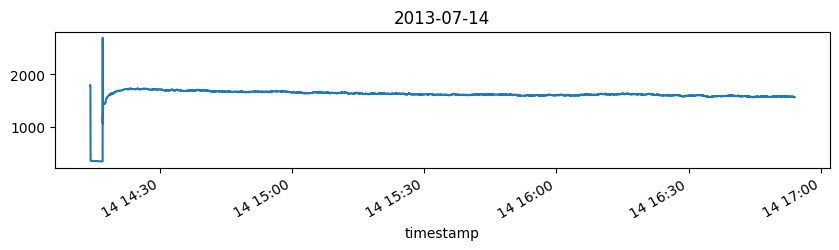

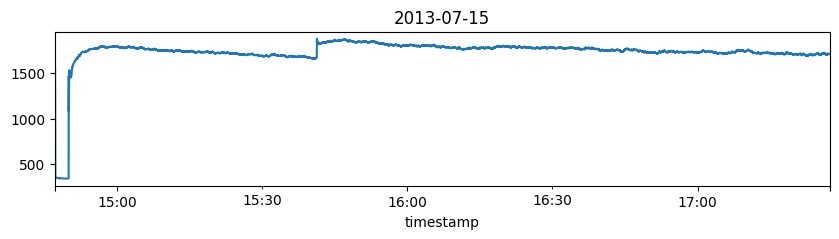

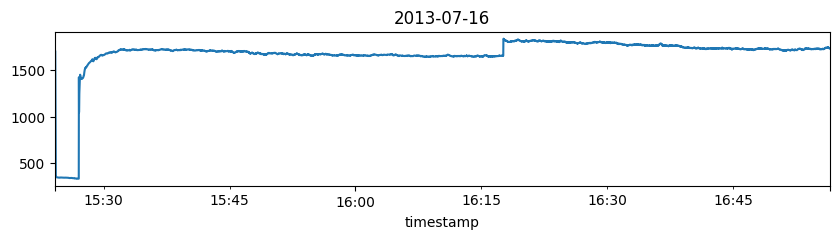

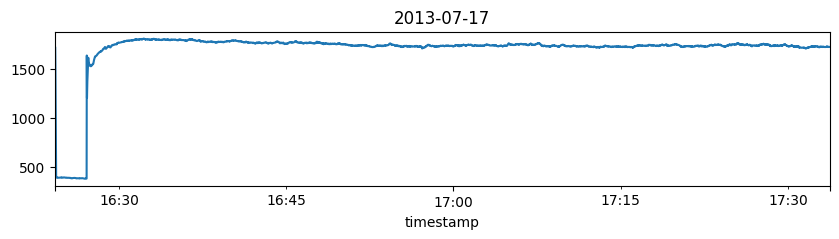

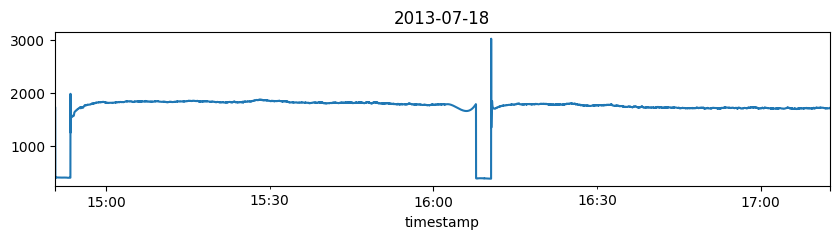

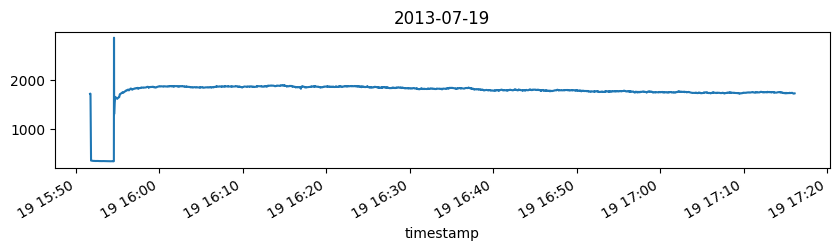

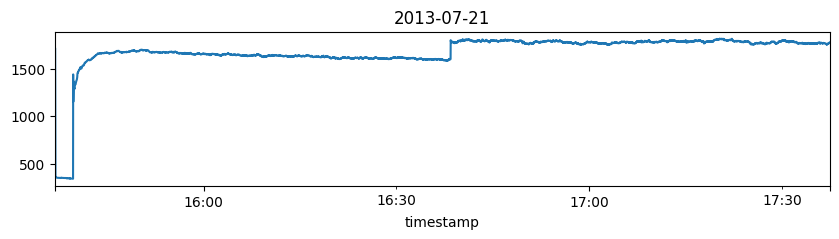

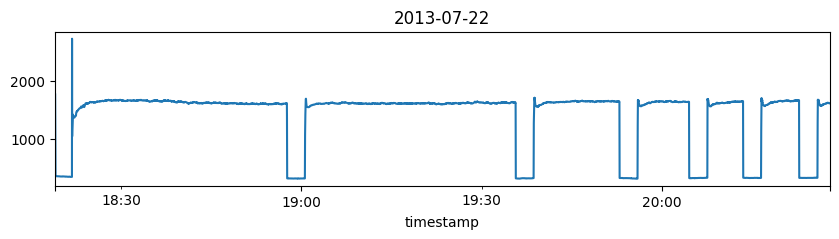

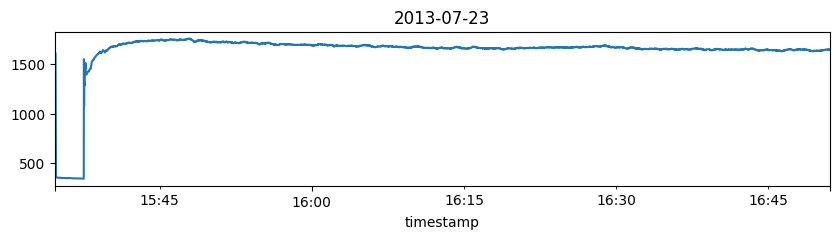

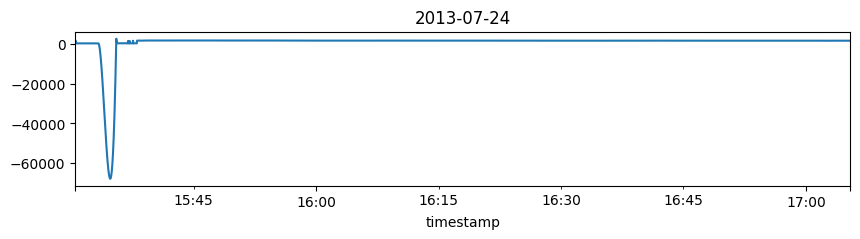

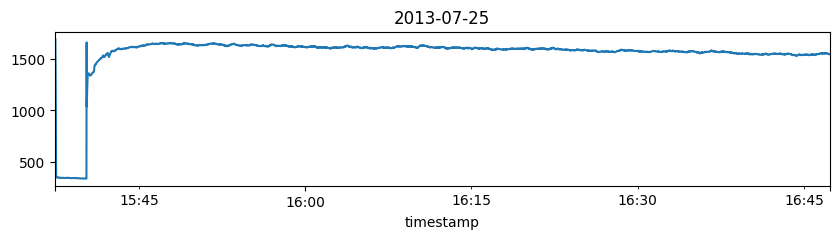

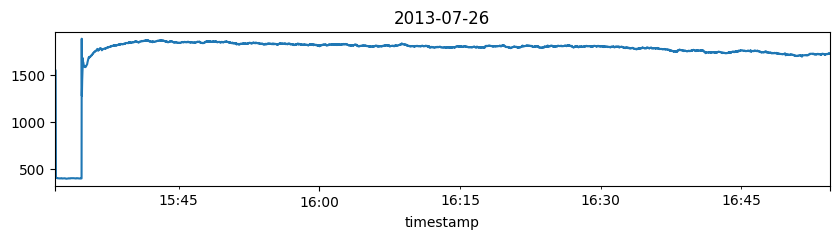

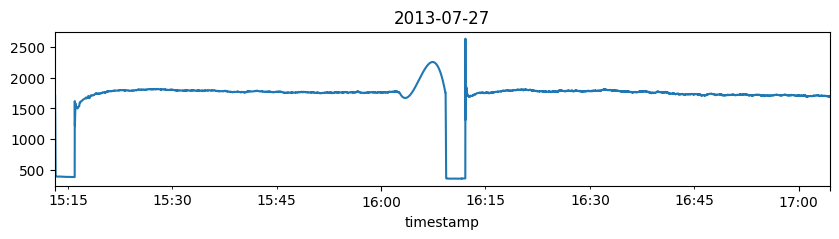

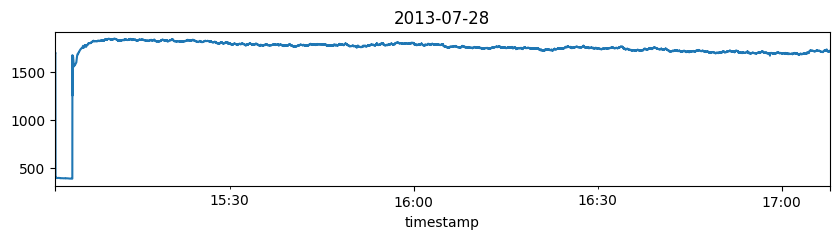

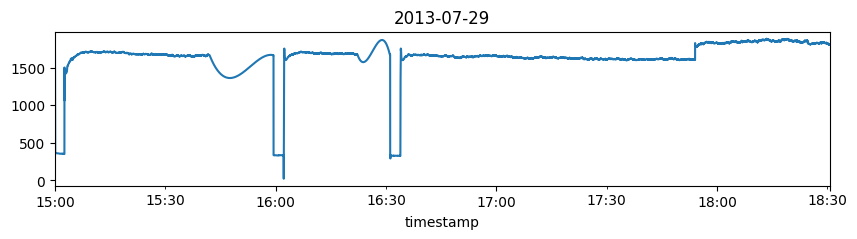

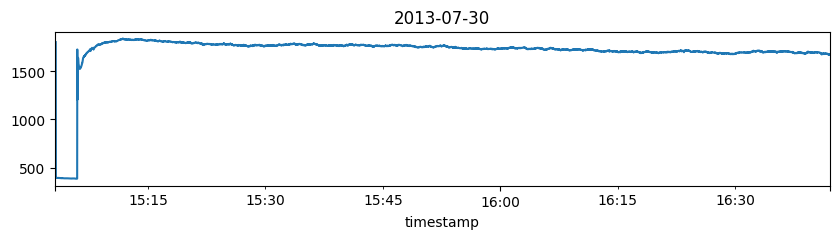

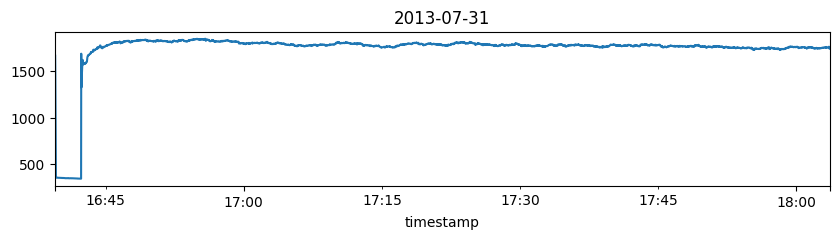

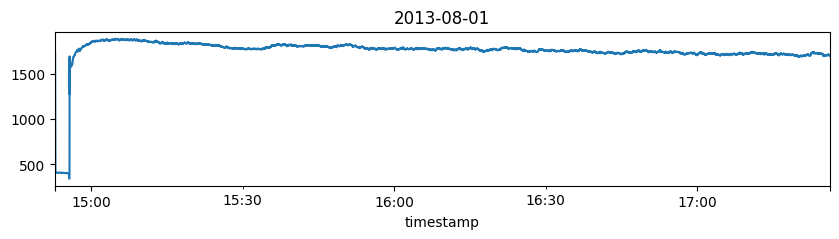

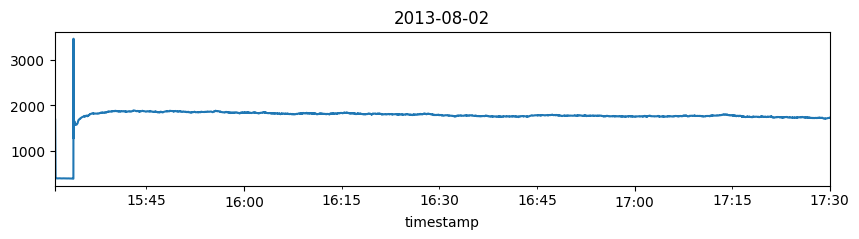

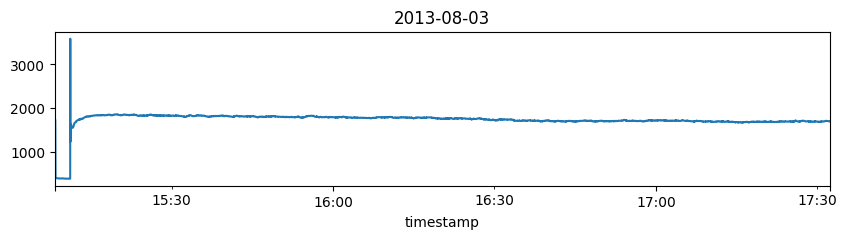

In [23]:
unique_dates = pd.Series(df.index.date).unique()
for date1 in unique_dates:
    # print(date1)
    df_date = df[df.index.to_series().dt.date == date1]
    df_date['ac1_A'].plot()
    plt.title(f"{date1}")
    plt.show()

In [24]:
df.to_csv("d:/clean_data/c_ac.csv")
df= pd.read_csv("d:/clean_data/c_ac.csv")
df

,timestamp,ac1_A,ac1_V,ac1_C
0,2013-06-12 15:37:44,1695.42,206.51,8.318
1,2013-06-12 15:37:45,1693.94,206.49,8.320
2,2013-06-12 15:37:46,1692.68,206.57,8.319
3,2013-06-12 15:37:47,1693.01,206.50,8.315
4,2013-06-12 15:37:48,1693.09,206.56,8.313
...,...,...,...,...
347601,2013-08-03 17:32:16,1695.33,203.78,8.429
347602,2013-08-03 17:32:17,1698.77,203.82,8.453
347603,2013-08-03 17:32:18,1697.96,203.83,8.440
347604,2013-08-03 17:32:19,1698.43,203.91,8.439


In [10]:
lst = ['ac1']
path = "d:/NILM/Data_files/Parquet/Appliances12_06_04_08/"
print("data read done")
""" data ingestion done """

""" data transformation """
complete_data_lst = [] # empty list to store final data set of all appliances
for i in range(len(lst)):
    df = pd.read_parquet(f"{path}{lst[i]}.parquet")
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.drop_duplicates(inplace=True)  
    df.set_index(['timestamp'],inplace=True ,drop=True)
    df.drop(df[(df['frequency']>51) | (df['frequency']<49)].index, inplace=True)
    df.drop(df[(df['PF']>1) | (df['PF']<0)].index, inplace=True)
    # df.drop(df[(df['current']>20) |(df['current']<0.07)].index, inplace=True)
    df.drop(df[df['voltage']<140].index, inplace=True)
    
    # power is active power derived from voltage current and pf
    df['power'] = (df['voltage'] * df['current'] * df['PF']).round(2)
    
    if lst[i]=="f":
        df_appliance = df[['power',"voltage",'current']].resample(rule="1s").asfreq()
        df_appliance = df_appliance.rename(columns={'power': f'{lst[i]}_A', 'voltage': f'{lst[i]}_V', 'current': f'{lst[i]}_C'})
    else:
        df_sample_lst = [] # empty list for storing resampled data at 1sec frequency of each hour
        unique_dates = pd.Series(df.index.date).unique()
        for date1 in unique_dates: # dates when applince is on                             
            df_date = df[df.index.to_series().dt.date == date1] # dataframe of that perticular date
            hours = df_date.index.hour.unique() # hours when appliance is on
            for h in hours:
                date2 = f"{date1} {h:02d}"
                df_hour = df_date.loc[date2] # dataframe of that perticular hour at which appliance was on
                mins = df_hour.index.minute.unique()
                for m in mins:
                    date3 = f"{date2}{m:02d}"
                    df_min = df_hour.loc[date3]
                    df_resampled_min = df_min[['power',"voltage",'current']].resample(rule="1s").asfreq()
                    df_sample_lst.append(df_resampled_min) # adding each hour data in lst
        df_appliance = pd.concat(df_sample_lst) # concating all hours data into single data frame with missing values within signature
        df_appliance = df_appliance.rename(columns={'power': f'{lst[i]}_A', 'voltage': f'{lst[i]}_V', 'current': f'{lst[i]}_C'})
        # df_appliance = create_features(df_appliance)
    complete_data_lst.append(df_appliance) # all applince data in list

data read done


In [12]:
df = complete_data_lst[0]

In [13]:
print(len(df))
print(df.isna().sum())
df

341412
ac1_A    3680
ac1_V    3680
ac1_C    3680
dtype: int64


,ac1_A,ac1_V,ac1_C
timestamp,,,
2013-06-12 15:37:44,1695.42,206.51,8.318
2013-06-12 15:37:45,1693.94,206.49,8.320
2013-06-12 15:37:46,1692.68,206.57,8.319
2013-06-12 15:37:47,1693.01,206.50,8.315
2013-06-12 15:37:48,1693.09,206.56,8.313
...,...,...,...
2013-08-03 17:32:16,1695.33,203.78,8.429
2013-08-03 17:32:17,1698.77,203.82,8.453
2013-08-03 17:32:18,1697.96,203.83,8.440


In [14]:
df=create_features(df)
original_timestamps = df.index
knn_imputer = KNNImputer(n_neighbors=1)
imputed_data = knn_imputer.fit_transform(df)

imputed_df1 = pd.DataFrame(imputed_data, columns=df.columns)
imputed_df1['Timestamp'] = original_timestamps
imputed_df1.set_index(['Timestamp'],drop=True,inplace=True)
# sliderPlot(df['ac1_A'].loc['2013-06-18'],t="line")
# sliderPlot(imputed_df['ac1_A'].loc['2013-06-18'],t="line")


In [15]:
df = imputed_df1[["ac1_A","ac1_V","ac1_C"]]

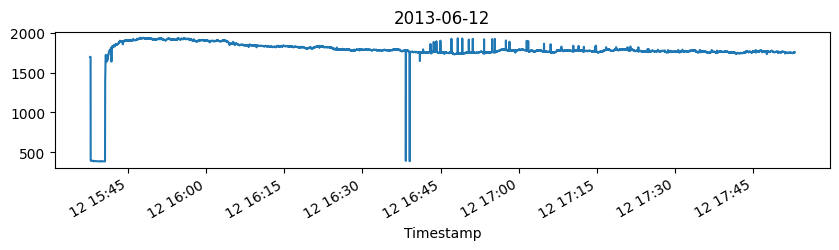

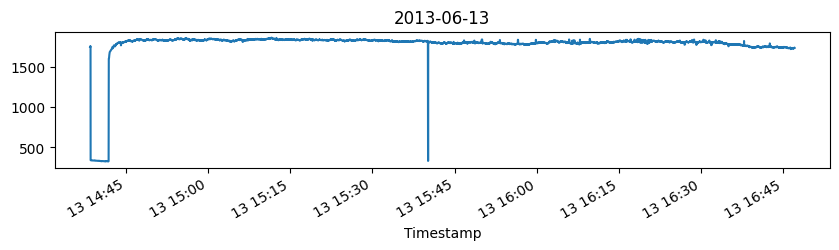

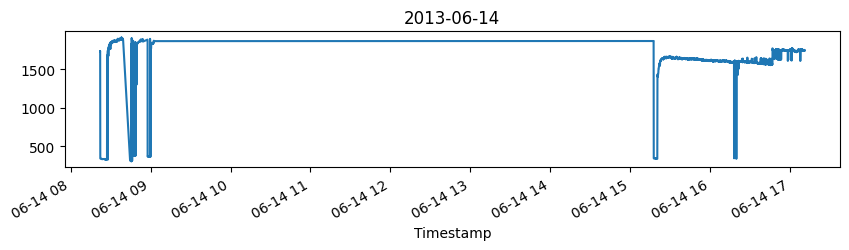

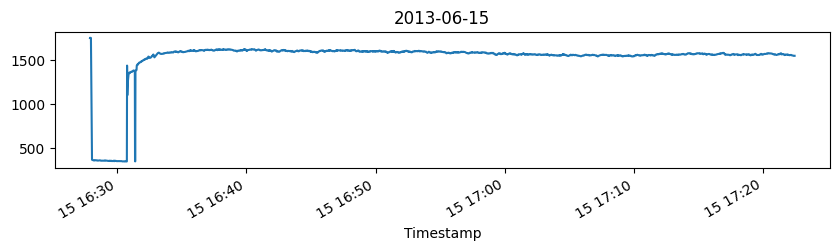

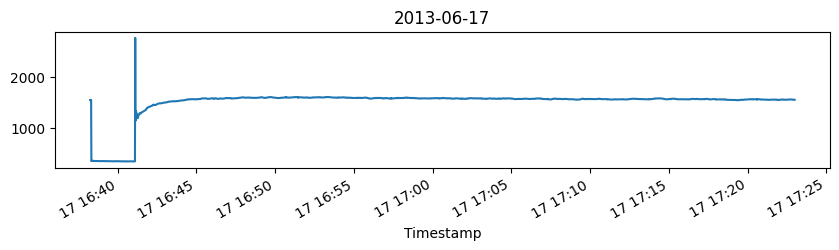

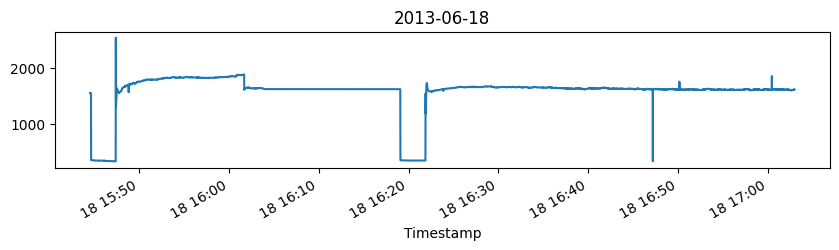

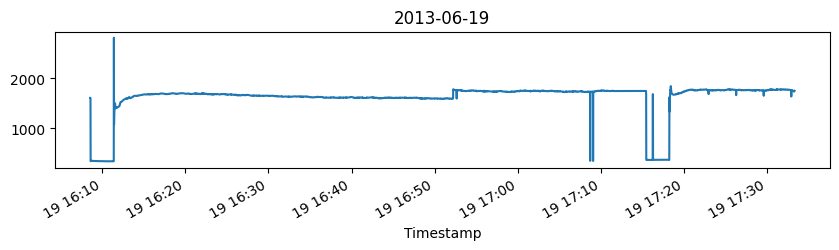

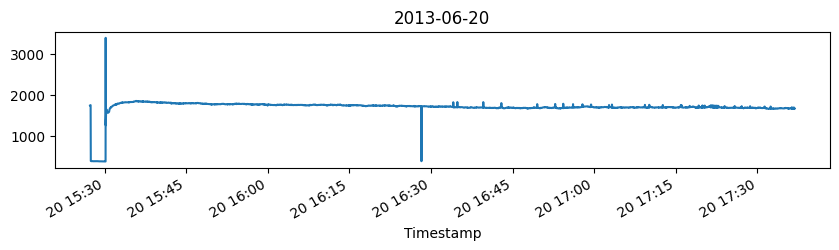

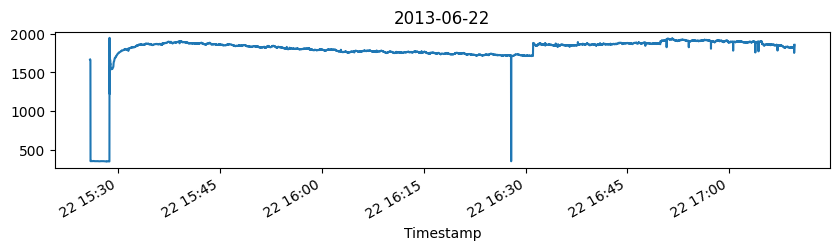

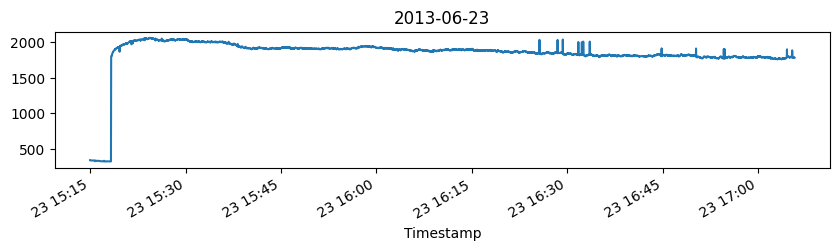

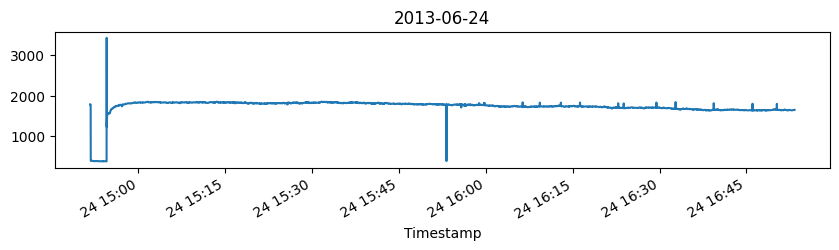

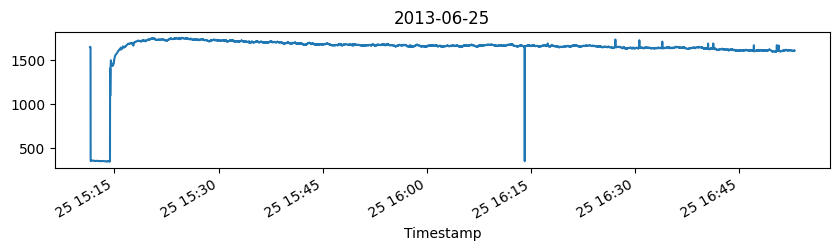

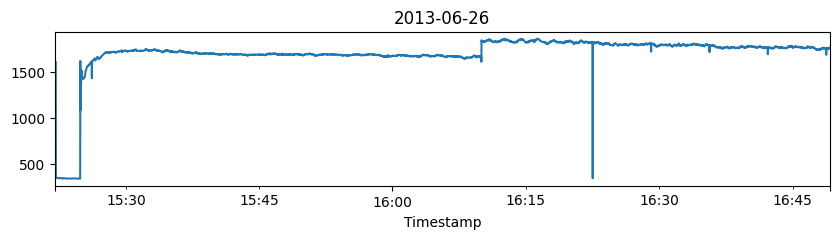

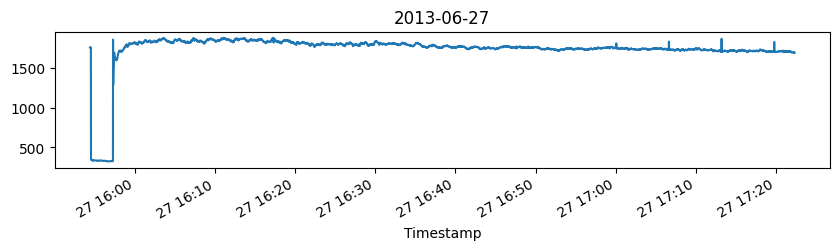

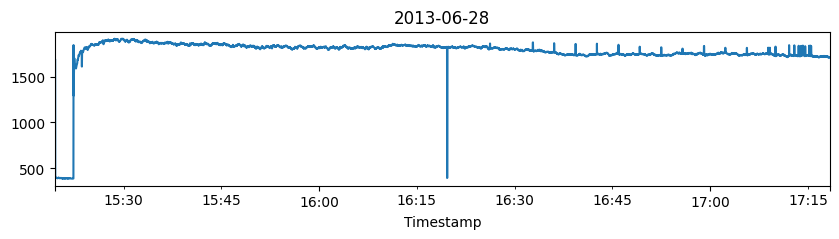

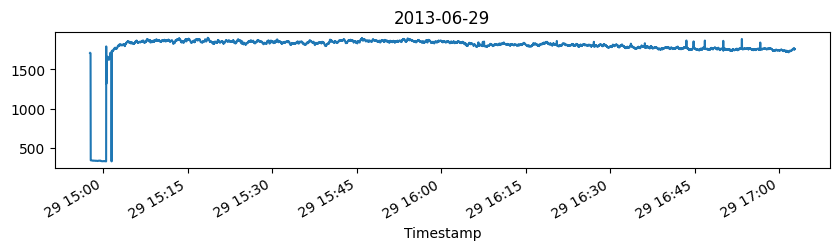

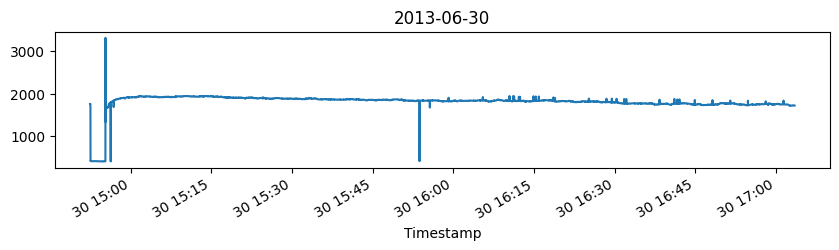

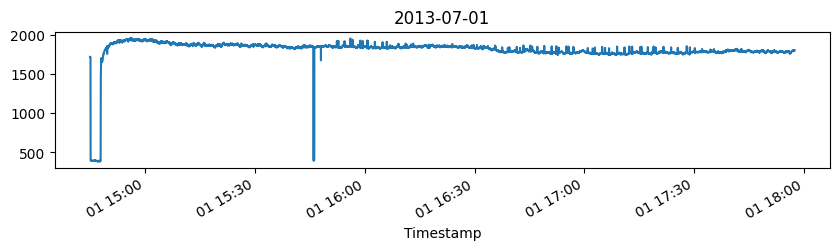

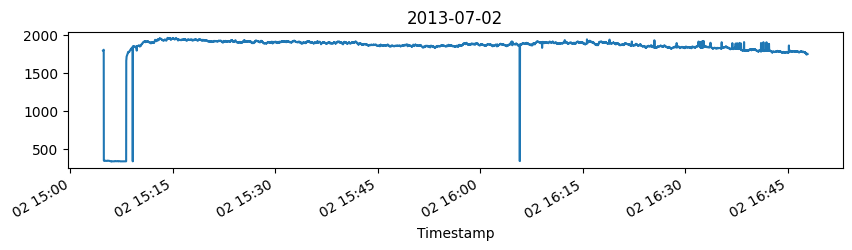

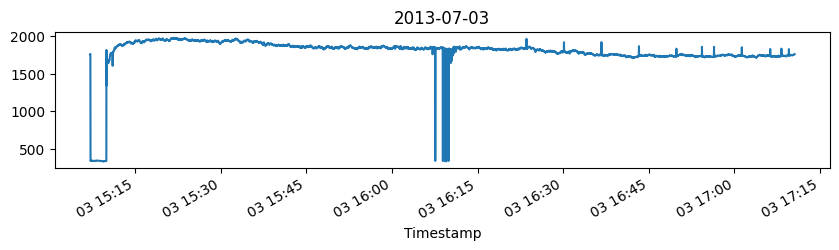

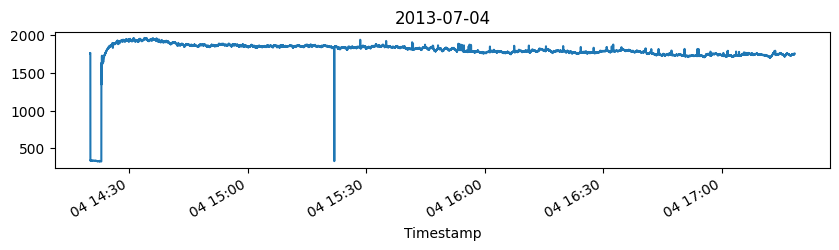

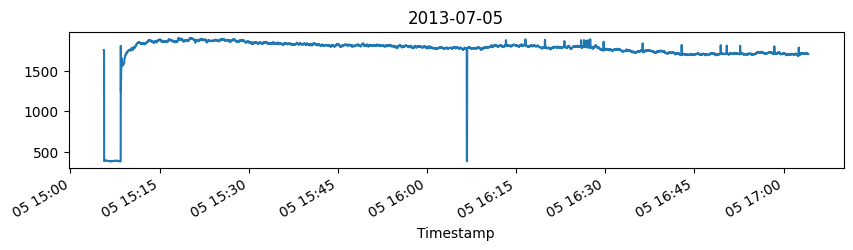

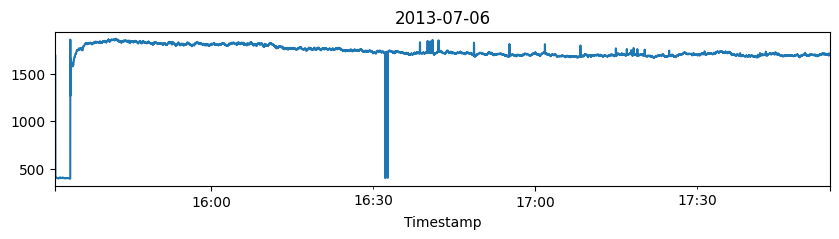

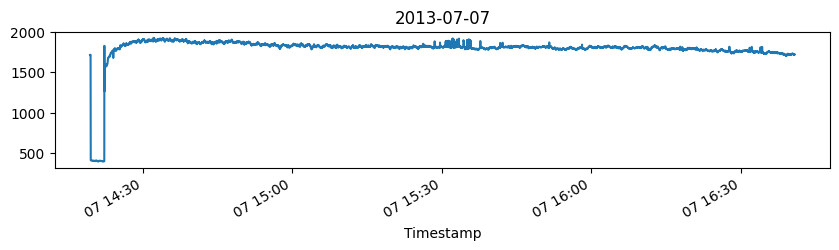

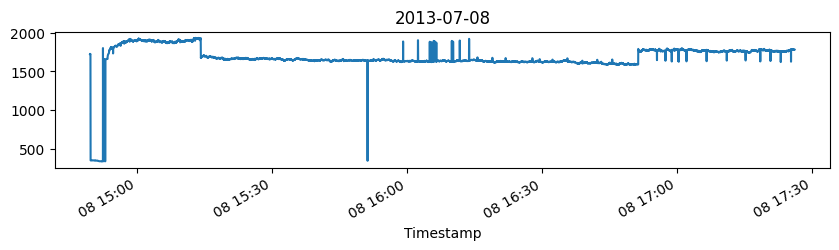

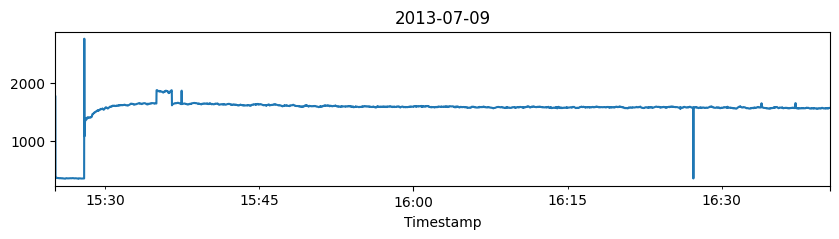

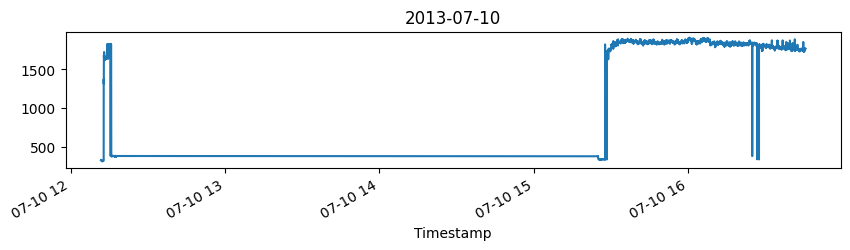

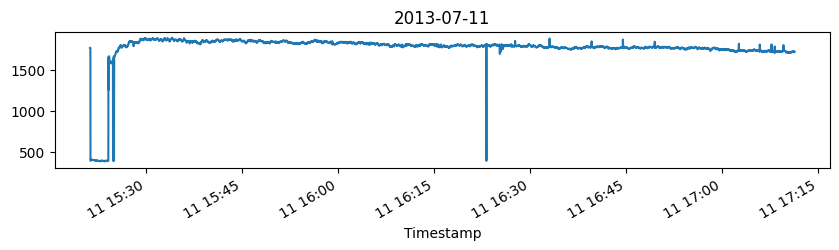

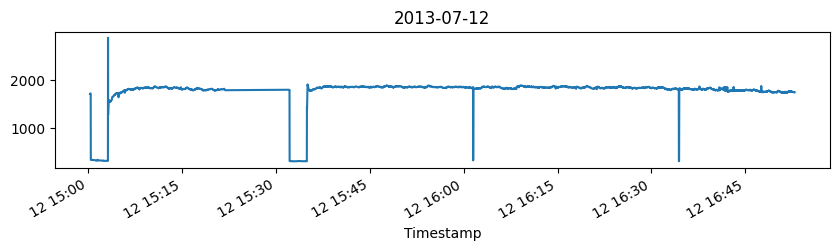

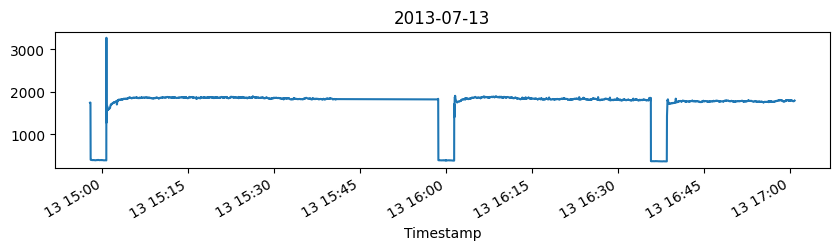

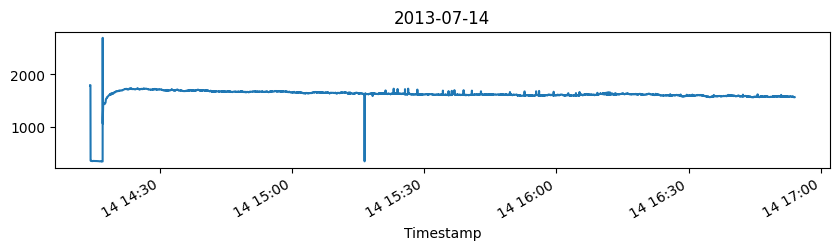

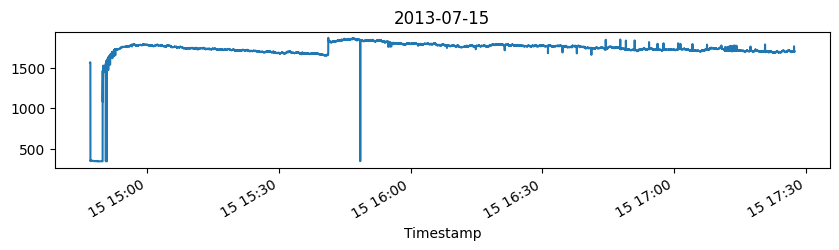

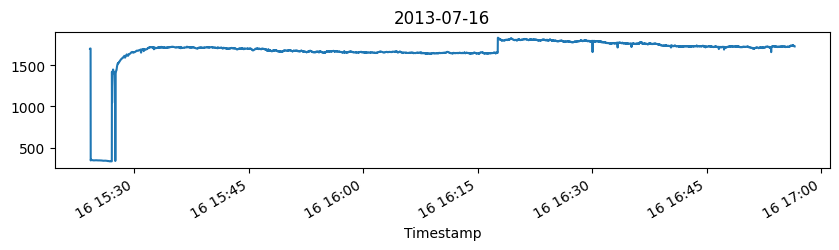

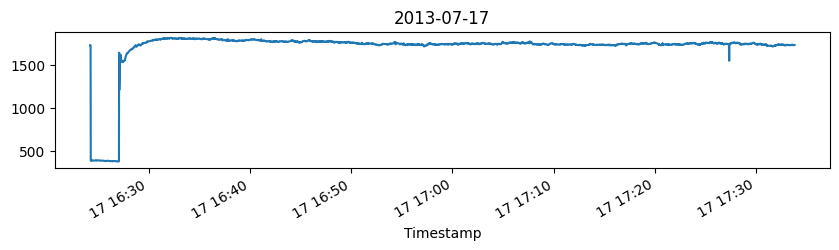

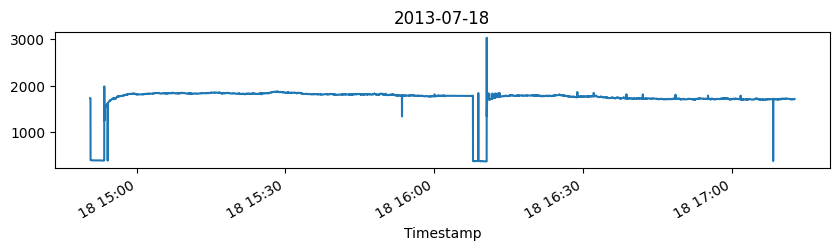

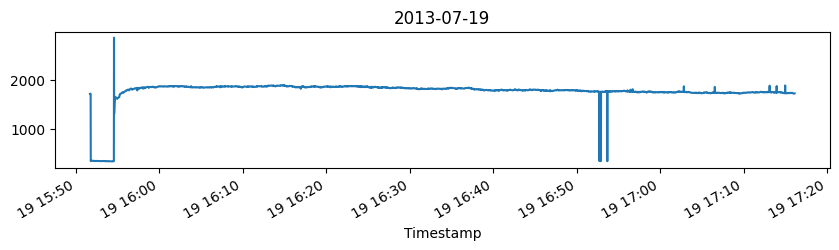

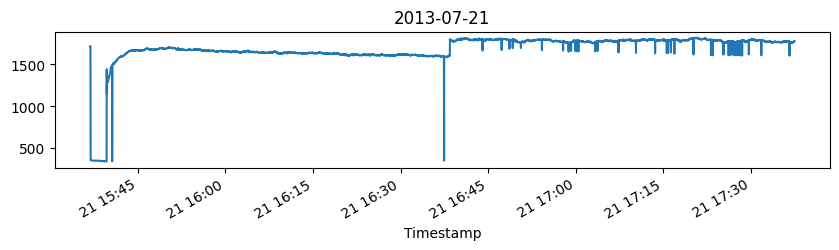

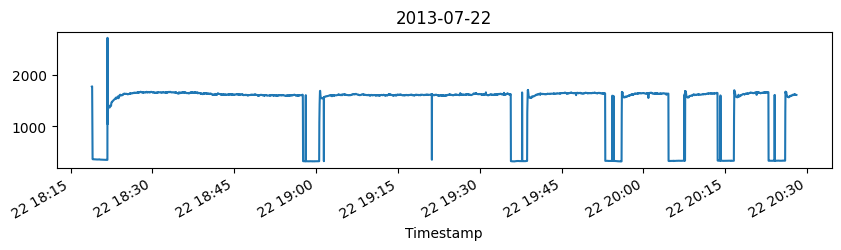

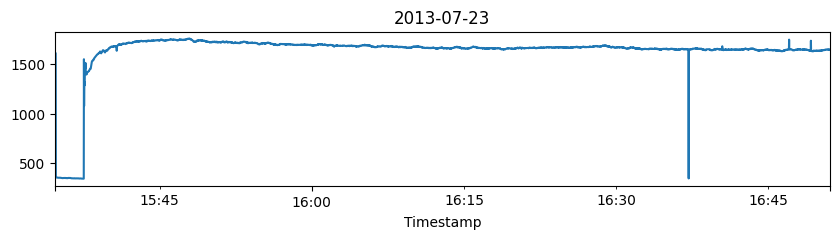

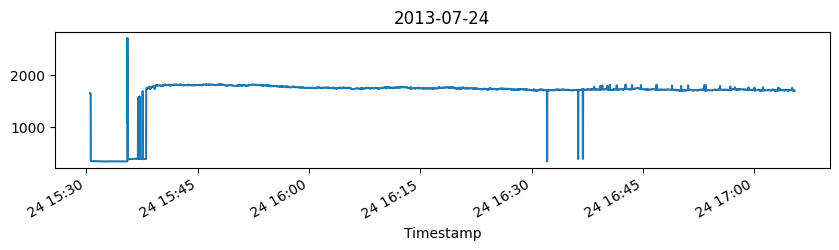

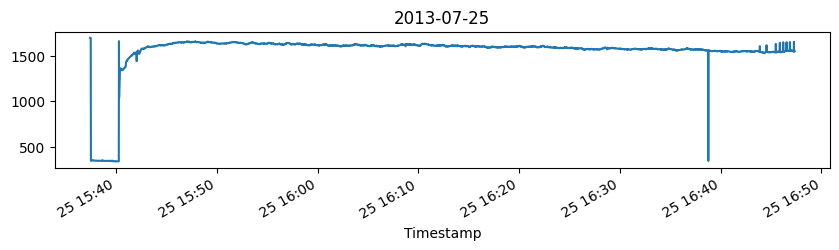

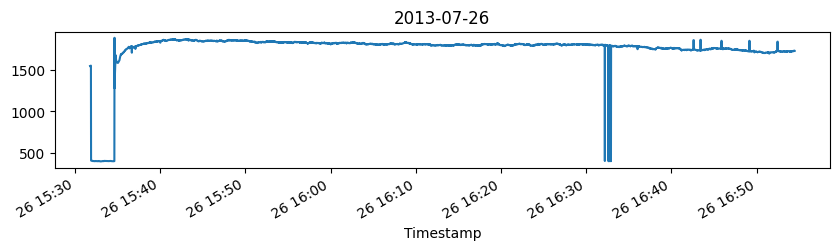

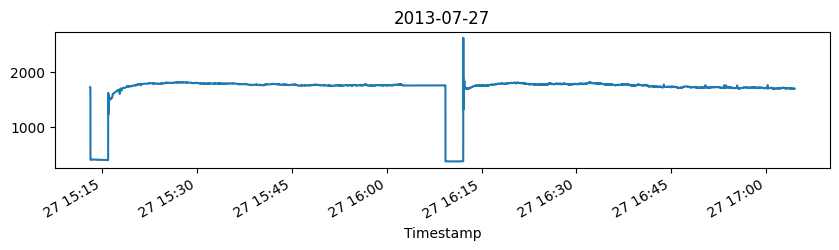

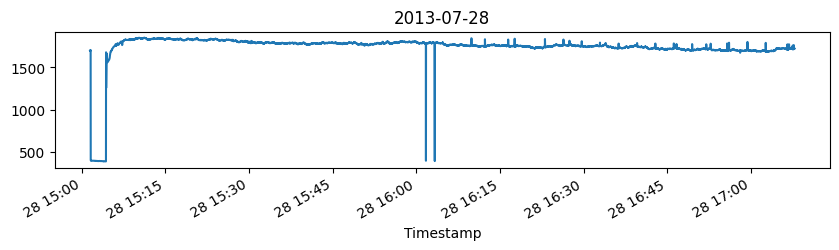

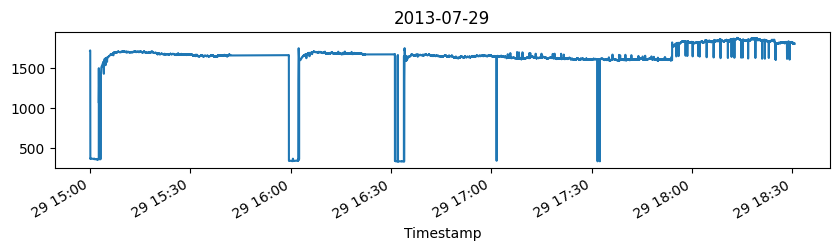

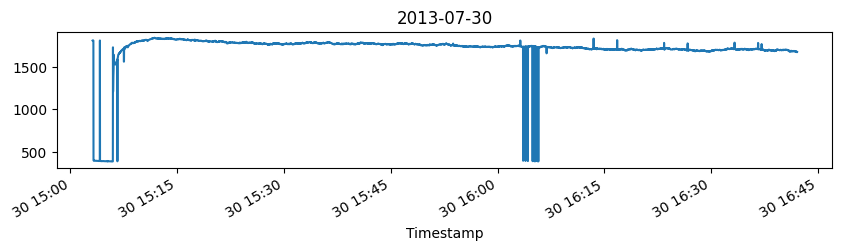

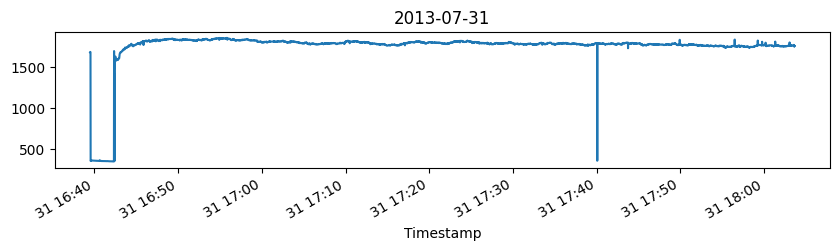

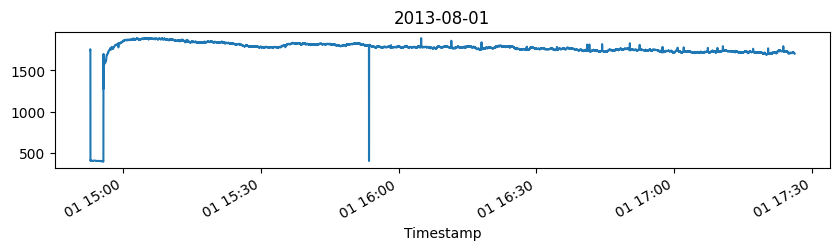

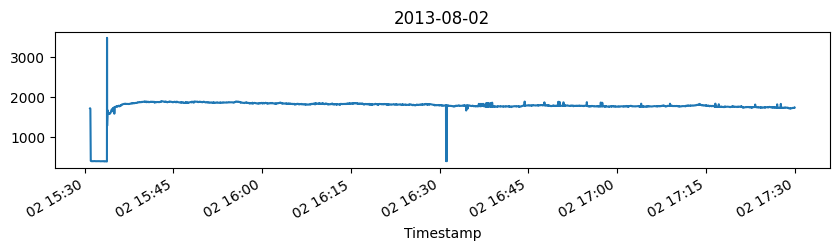

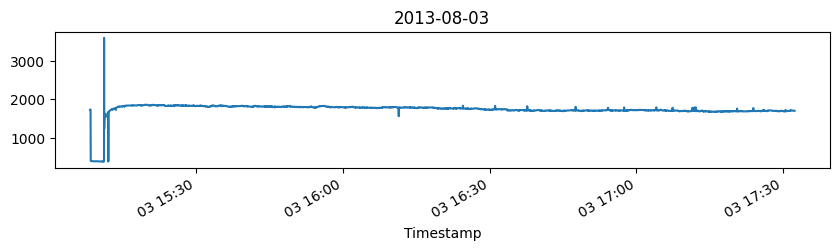

In [16]:
unique_dates = pd.Series(df.index.date).unique()
for date1 in unique_dates:
    # print(date1)
    df_date = df[df.index.to_series().dt.date == date1]
    df_date['ac1_A'].plot()
    plt.title(f"{date1}")
    plt.show()

In [8]:
df.describe()

,ac1_A,ac1_V,ac1_C
count,337732.000000,337732.000000,337732.000000
mean,1709.003410,217.402746,8.101514
std,268.943132,11.666274,1.426605
min,307.530000,159.840000,1.436000
25%,1689.620000,211.210000,7.581000
50%,1764.675000,218.520000,8.498000
75%,1820.652500,225.060000,8.673000
max,3590.700000,245.230000,18.646000


<Axes: xlabel='timestamp'>

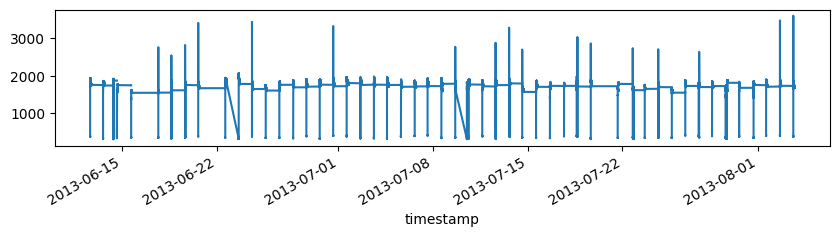

In [9]:
df['ac1_A'].plot()

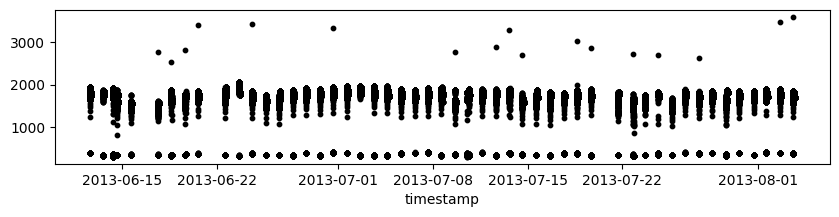

In [10]:
scatter(df['ac1_A'])

<Axes: xlabel='timestamp'>

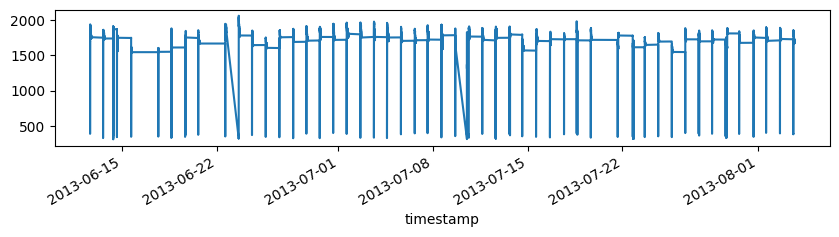

In [13]:
df1 = df[df['ac1_A']<2100]
df1['ac1_A'].plot()

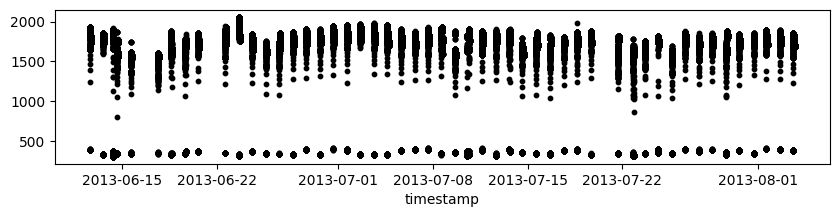

In [17]:
scatter(df1['ac1_A'])

In [18]:
df1.describe()

,ac1_A,ac1_V,ac1_C
count,337715.000000,337715.000000,337715.000000
mean,1708.938890,217.402485,8.101156
std,268.785765,11.666322,1.425691
min,307.530000,159.840000,1.436000
25%,1689.610000,211.210000,7.581000
50%,1764.670000,218.520000,8.498000
75%,1820.650000,225.060000,8.673000
max,2060.420000,245.230000,18.646000


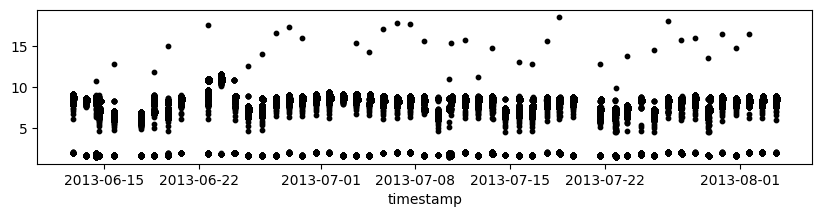

In [19]:
scatter(df1['ac1_C'])

In [20]:
sliderPlot(df1['ac1_C'].loc["2013-06-14"],t="line")

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_tv.index, df_tv['active power'], label='Original Data - Active Power')
plt.plot(df_tv['active power'].rolling(window=12).mean(), label='Rolling Mean (window=12)')
plt.plot(df_tv['active power'].rolling(window=12).std(), label='Rolling Std (window=12)')
plt.title('Original Time Series Data - Active Power with Rolling Mean and Rolling Std')
plt.xlabel('Timestamp')
plt.ylabel('Active Power')
plt.legend()
plt.show()

In [16]:
sliderPlot(df['ac1_A'].loc['2013-07-10'])